In [8]:
import logging
import os
import shutil 

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm

from gensim.models import FastText
from gensim.test.utils import common_texts

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster
from sklearn.cluster import DBSCAN

## Предобработка данных

In [13]:
file = os.path.join(r'C:\Users\posch\Downloads\winemag-data-130k-v2.csv')

data = pd.read_csv(file, sep=',',  on_bad_lines='skip')

print(data.shape)
data.head(5)

(129971, 14)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [15]:
data.describe()

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [16]:
mydata = data.drop(['Unnamed: 0', 'designation',	'description',	'region_1',	'region_2',	'taster_name',	'taster_twitter_handle',	'title', 'variety', 'winery'], axis=1)

In [17]:
mydata.isna().any()

country      True
points      False
price        True
province     True
dtype: bool

In [18]:
print(mydata.shape)
mydata = mydata.dropna()
mydata.shape

(129971, 4)


(120916, 4)

In [19]:
mydata.head()

,country,points,price,province
1,Portugal,87,15.0,Douro
2,US,87,14.0,Oregon
3,US,87,13.0,Michigan
4,US,87,65.0,Oregon
5,Spain,87,15.0,Northern Spain


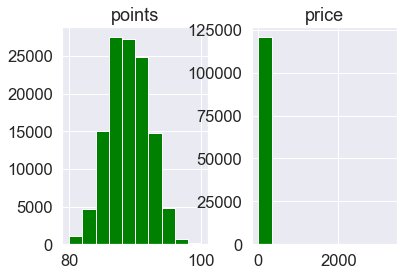

In [20]:
sns.set(font_scale=1.5, rc={'figure.figsize':(6, 3)})

ax=mydata.hist(color='green' )

In [22]:
model = FastText(vector_size=1, window=3, min_count=1, sentences=common_texts, epochs=10)

In [23]:
country_vectors = []
for x in mydata.country:
    vec = list(model.wv[x])
    country_vectors.append(vec)

In [24]:
country_vec = pd.DataFrame(country_vectors,
                        columns=['c1'])

In [25]:
province_vectors = []
for x in mydata.province:
    vec = list(model.wv[x])
    province_vectors.append(vec)

In [26]:
province_vec = pd.DataFrame(province_vectors,
                        columns=['p1'])

In [27]:
result = mydata.join(country_vec, how='left')
result = result.join(province_vec, how='left')
result

,country,points,price,province,c1,p1
1,Portugal,87,15.0,Douro,0.143106,-0.159020
2,US,87,14.0,Oregon,0.143106,0.168213
3,US,87,13.0,Michigan,0.143106,-0.159020
4,US,87,65.0,Oregon,0.190019,0.091824
5,Spain,87,15.0,Northern Spain,-0.042943,-0.071558
...,...,...,...,...,...,...
129966,Germany,90,28.0,Mosel,NaN,NaN
129967,US,90,75.0,Oregon,NaN,NaN
129968,France,90,30.0,Alsace,NaN,NaN
129969,France,90,32.0,Alsace,NaN,NaN


In [28]:
data_sm = result[['points', 'price', "c1", "p1"]
              ]


data_sm.head(3)

,points,price,c1,p1
1,87,15.0,0.143106,-0.159020
2,87,14.0,0.143106,0.168213
3,87,13.0,0.143106,-0.159020


In [29]:
data_sm.isna().any()

points    False
price     False
c1         True
p1         True
dtype: bool

In [30]:
data_sm.fillna(data_sm.mean())

,points,price,c1,p1
1,87,15.0,0.143106,-0.159020
2,87,14.0,0.143106,0.168213
3,87,13.0,0.143106,-0.159020
4,87,65.0,0.190019,0.091824
5,87,15.0,-0.042943,-0.071558
...,...,...,...,...
129966,90,28.0,0.025751,-0.031034
129967,90,75.0,0.025751,-0.031034
129968,90,30.0,0.025751,-0.031034
129969,90,32.0,0.025751,-0.031034


In [31]:
std_scaler = StandardScaler()
data_scaled=data_sm.copy()
data_scaled[data_scaled.columns]=std_scaler.fit_transform(data_scaled)

In [32]:
data_scaled.head(3)

,points,price,c1,p1
1,-0.466915,-0.496422,0.620126,-1.381473
2,-0.466915,-0.520794,0.620126,2.150659
3,-0.466915,-0.545166,0.620126,-1.381473


In [33]:
data_scaled.isna().any()

points    False
price     False
c1         True
p1         True
dtype: bool

In [34]:
print(data_scaled.shape)
data_scaled = data_scaled.dropna()
data_scaled.shape

(120916, 4)


(112470, 4)

In [35]:
data_scaled = data_scaled.fillna(data_scaled.mean())

In [36]:
data_scaled.isna().any()

points    False
price     False
c1        False
p1        False
dtype: bool

<AxesSubplot: >

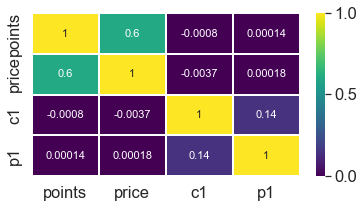

In [37]:
corr = data_scaled.corr(method="spearman")

plt.figure(figsize=(6,3))

sns.heatmap(corr, linewidths=.4, cmap='viridis', annot=True,annot_kws={"size": 11})

In [38]:
pca_2 = PCA(2)

pca_2_result = pca_2.fit_transform(data_scaled) 

pca_2_result.shape 


(112470, 2)

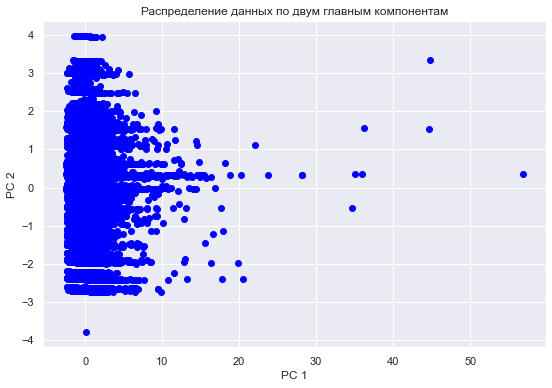

In [39]:
sns.set(rc={'figure.figsize':(9,6)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue') 
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

# K-**means**

In [70]:
kmeans = cluster.KMeans(n_clusters = 2,
               init='k-means++',
               n_init=15,
               max_iter=500, 
               random_state=17
    ) 
    
    
kmeans.fit(pca_2_result)
print(kmeans.inertia_)

204156.51498544065


### на два типа вино делится плохо 

(а жаль, из прагматических соображений было бы здорово отделить "хорошее" от "плохого")

In [71]:
kmeans.fit(data_scaled)
print(kmeans.inertia_)

359138.7630711674


In [72]:
data_scaled.shape

(112470, 5)

In [73]:
inertia = []
for i in tqdm(range(2,30)): 
    
    kmeans = cluster.KMeans(
               n_clusters=i, 
               init='k-means++',
               n_init=15, 
               max_iter=500,
               random_state=17
    ) 
    
    
    kmeans.fit(pca_2_result) # обучаем модель 
    inertia.append(kmeans.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [01:27<00:00,  3.13s/it]


In [74]:
for i in inertia:
    print(i)

204156.51498544065
135718.61198125556
110511.5430025331
90775.16956533317
76061.39309886245
66468.87822256761
58129.76368843987
51801.921433526935
45736.38257531398
40587.49822241021
36867.936489506625
33944.302654508305
31547.857138541713
29190.88734051753
27184.987658293558
25706.307851424306
24328.17268903728
23114.258355720456
21789.430558025982
20738.355354353243
19894.682916939575
18903.170020728434
18042.63756181106
17180.566849548108
16647.009802087006
16021.212082612414
15473.845748621676
15013.89146136089


In [75]:
from sklearn.metrics import silhouette_score

silhouette = {}
for i in tqdm(range(2, 30)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(pca_2_result)
    
    silhouette[i] = silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean')

100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [1:32:03<00:00, 197.28s/it]


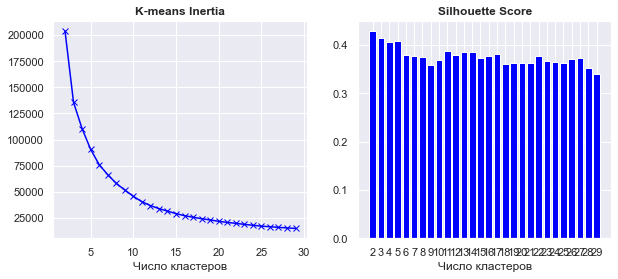

In [76]:
sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue') 

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()


In [77]:
kmeans = cluster.KMeans(n_clusters=5,random_state=17,init='k-means++')

kmeans_labels = kmeans.fit_predict(pca_2_result)


centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts()) 


0    49875
3    30579
1    16759
4    14611
2      646
dtype: int64

In [78]:
kmeans_labels

array([0, 4, 0, ..., 1, 1, 1])

In [79]:
data_scaled['Cluster']=kmeans_labels

pca_2_df = pd.DataFrame(pca_2_result)
pca_2_df['Cluster']=kmeans_labels

pca_2_df

,0,1,Cluster
0,-0.687251,-0.534938,0
1,-0.680020,1.962561,4
2,-0.722115,-0.534972,0
3,0.203311,1.555697,4
4,-0.680953,-0.562560,0
...,...,...,...
112465,-1.688449,-2.694675,1
112466,-1.692458,-0.524408,0
112467,-1.837827,-2.611151,1
112468,-1.402036,-2.610726,1


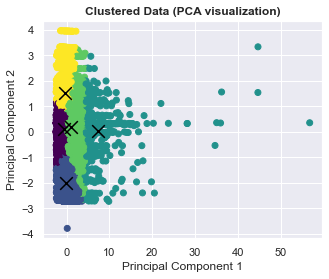

In [80]:
sns.set( rc={'figure.figsize':(5,4)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=160, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


plt.title('Clustered Data (PCA visualization)',fontweight='bold')

plt.show()


In [81]:
print("Inertia score: %0.1f" % kmeans.inertia_,
     "\nSilhouette score: %0.1f" % silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean'))

Inertia score: 90775.2 
Silhouette score: 0.4


# DBSCAN

In [82]:
from sklearn.cluster import DBSCAN

In [85]:
X = data_scaled.drop("Cluster",axis=1)
cluster = DBSCAN(min_samples=3, eps=0.9) 
cluster.fit(X)

DBSCAN(eps=0.9, min_samples=3)

In [86]:
data_scaled['Cluster'] = cluster.labels_
data_scaled['Cluster'].value_counts()

 0    112331
-1       117
 1         9
 3         7
 2         3
 4         3
Name: Cluster, dtype: int64

In [87]:
data_scaled['Cluster'] = cluster.labels_
data_scaled.groupby(['Cluster']).mean()

,points,price,c1,p1
Cluster,,,,
-1,1.823568,14.549155,-0.432297,0.119982
0,-0.005749,-0.019414,0.000376,-0.000296
1,2.598290,18.250974,0.662409,-0.260677
2,1.284631,4.215476,0.823876,3.161099
3,2.301153,11.546771,-0.371611,1.122282
4,2.050932,11.153339,0.829610,1.404251


In [88]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X,cluster.labels_))

Silhouette Coefficient: 0.571


# **Результаты**

Для классификации я выбрала следующие параметры: страну, провинцию, цену и финальную оценку вина. 

## K-means

На основе получившихся метрик можно сделать вывод о том, что в датасете представлены очень разнообразные вина. И их достаточно сложно распределить на маленькое количество классов. При увеличении количества кластеров Inertia score уменьшалась лишь незначительно, Silouette score оставалась неизменной. Возможно подобрать количество классов вручную, предположительно их должно быть около 10.

Приведу результаты предыдущего эксперимента, при k=4:

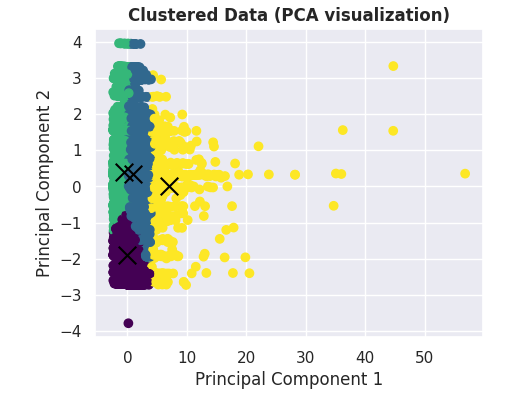

Inertia score: 110511.5

Silhouette score: 0.4

## DBSCAN

Результат получился лучше, чем с K-means, Silhouette score на 0.17 выше. Тем не менее, достаточно далека от единицы.